#**Quantum Classifier - simulator and IQM Spark (Odra 5) comparison**
Authors: Axion Science Club, WUST, Poland

**Dataset:** Banknote Authentication (UCI ML Repository)

**Framework:** Qiskit Machine Learning + PyTorch

**Abstract**

This notebook investigates the performance of the **Ansatz 2: Star-Topology Hardware-Efficient (IQM Spark Optimized)** for binary classification using the banknote authentication dataset. We conduct a comparative analysis between results obtained from an ideal statevector simulator and those executed on IQM Spark Odra 5 superconducting quantum processor.

While the simulator provides a noise-free baseline for convergence, the experimental results highlight the impact of [POOOOPRAWWW mention specific noise types, e.g., gate fidelity / readout error] in the NISQ era. We also explore the efficacy of [mention error mitigation if used, e.g., readout error mitigation / Richardson extrapolation] in recovering the signal on real hardware. The findings demonstrate that while the ansatz is theoretically sound, hardware implementation requires careful consideration of circuit depth and connectivity.



**Environment Setup**

This section handles dependency installation and imports. For reproducibility, all package versions should be pinned in a production environment.

In [ ]:
# Optional: Install dependencies if not already present
INSTALL_DEPS = False

if INSTALL_DEPS:
    import sys
    import subprocess

    packages = [
        'numpy',
        'scikit-learn',
        'ucimlrepo',
        'qiskit',
        'qiskit-machine-learning',
        'torch',
        'matplotlib'
    ]

    for pkg in packages:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', pkg])

**Imports**

In [ ]:
# Standard library
import random
import time

# Third-party: Scientific computing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Third-party: Machine learning

import sys
import subprocess

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from ucimlrepo import fetch_ucirepo

# Third-party: Quantum computing
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator, PrimitiveResult, PubResult
from qiskit.primitives.base import BaseEstimatorV2
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives.containers.data_bin import DataBin
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN

#Third-party: Setting up Quantum Hardware
from iqm.qiskit_iqm import IQMProvider



/home/maria/AXION/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Reproducibility and Random Seed Control**

In [ ]:
def set_random_seed(seed: int = 42) -> None:
    """
    Set random seeds for reproducibility across numpy, PyTorch, and Python's random module.

    Parameters
    ----------
    seed : int
        Random seed value (default: 42)
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Set global seed
RANDOM_SEED = 42
set_random_seed(RANDOM_SEED)

In [ ]:
def ensure_package(pkg_name, import_name=None):
    import_name = import_name or pkg_name
    try:
        __import__(import_name)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg_name])

# Ensure all requirements are met
ensure_package('numpy')
ensure_package('scikit-learn', 'sklearn')
ensure_package('ucimlrepo')
ensure_package('qiskit')

### **Data Preparation**
The Banknote Authentication Dataset contains features extracted from images of genuine and forged banknotes. We perform feature engineering (interaction term) and scale features to the range [0, π] for angle encoding.

In [ ]:
def prepare_data(test_size: float = 0.2, random_state: int = 42):
    """
    Fetch and preprocess the Banknote Authentication dataset.

    The dataset contains 4 original features extracted from wavelet-transformed images:
    - Variance of image
    - Skewness of image
    - Curtosis of image
    - Entropy of image

    We engineer one additional interaction feature (variance × skewness) and scale
    all features to [0, π] for angle encoding in the quantum circuit.

    Parameters
    ----------
    test_size : float
        Fraction of data to reserve for testing (default: 0.2)
    random_state : int
        Random seed for train/test split (default: 42)

    Returns
    -------
    X_train : np.ndarray
        Training features, shape (n_train, 5), scaled to [0, π]
    X_test : np.ndarray
        Test features, shape (n_test, 5), scaled to [0, π]
    y_train : np.ndarray
        Training labels, shape (n_train,), values in {0, 1}
    y_test : np.ndarray
        Test labels, shape (n_test,), values in {0, 1}

    Notes
    -----
    - Dataset ID 267 from UCI ML Repository
    - Original features: 4, engineered features: 1, total: 5
    - Scaling range [0, π] is required for RY angle encoding gates
    """
    # Fetch dataset from UCI repository
    banknote_authentication = fetch_ucirepo(id=267)
    X = banknote_authentication.data.features.to_numpy()
    y = banknote_authentication.data.targets.to_numpy().ravel()

    # Sanity checks
    assert X.shape[1] == 4, f"Expected 4 features, got {X.shape[1]}"
    assert set(np.unique(y)) == {0, 1}, f"Expected binary labels {{0, 1}}, got {set(np.unique(y))}"

    # Feature engineering: interaction term
    variance = X[:, 0].reshape(-1, 1)
    skewness = X[:, 1].reshape(-1, 1)
    interaction = variance * skewness
    X_expanded = np.hstack((X, interaction))

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_expanded, y, test_size=test_size, random_state=random_state
    )

    # Scale features to [0, π] for angle encoding
    scaler = MinMaxScaler(feature_range=(0, np.pi))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"Dataset loaded: {len(X_train)} train, {len(X_test)} test samples")
    print(f"Feature dimension: {X_train_scaled.shape[1]}")
    print(f"Class distribution (train): {np.bincount(y_train.astype(int))}")

    return X_train_scaled, X_test_scaled, y_train, y_test

### **Ansatz 2: Star-Topology Hardware-Efficient (IQM Spark Optimized)**
Argumentation for usage of the said ansatz is aviable in [ansatz_comparison.ipynb](https://https://github.com/Kolo-Naukowe-Axion/QC1/blob/main/ansatz_comparison.ipynb) notebook.


In [ ]:
def ansatz(n_qubits, depth):
    """
    Constructs a hardware-efficient ansatz tailored for a star topology.
    QB3 (index 2) acts as the central hub for entanglement to avoid SWAP gates.
    Native CZ gates are used to minimize decomposition errors.
    """

    # Each full iteration (2 layers) consumes:
    # Layer 1: n_qubits (RY) + 4 (RZ before CZ) = 9 parameters
    # Layer 2: n_qubits (RX) + 4 (RY before CZ) = 9 parameters
    # Total = 18 parameters per iteration (where depth // 2 is the number of iterations)
    params_per_iter = 18
    total_params = params_per_iter * (depth // 2)
    theta = ParameterVector('θ', total_params)

    qc = QuantumCircuit(n_qubits)

    # The loop iterates (depth // 2) times to execute two-layer blocks.
    for j in range(depth // 2):
        offset = j * params_per_iter

        # -------- Layer 1: RY + Star CZ (RZ-based) --------

        # Sub-layer: Independent RY rotations on all qubits
        for i in range(n_qubits):
            qc.ry(theta[offset + i], i)

        # Sub-layer: Entanglement using Star Topology
        # QB3 (index 2) is the central qubit. We connect it to [0, 1, 3, 4].
        # RZ rotations are added to maintain expressibility while using native CZ.
        target_qubits = [0, 1, 3, 4]
        for idx, target in enumerate(target_qubits):
            # Using parameters offset+5 to offset+8
            qc.rz(theta[offset + n_qubits + idx], target)
            qc.cz(2, target)

        # -------- Layer 2: RX + Star CZ (RY-based) --------

        # Move the offset forward for the second layer within the same iteration
        offset_layer2 = offset + 9

        # Sub-layer: Independent RX rotations on all qubits
        for i in range(n_qubits):
            qc.rx(theta[offset_layer2 + i], i)

        # Sub-layer: Entanglement using Star Topology
        # RY rotations are used here to simulate the effect of a CRY-like interaction.
        for idx, target in enumerate(target_qubits):
            # Using parameters offset_layer2+5 to offset_layer2+8
            qc.ry(theta[offset_layer2 + n_qubits + idx], target)
            qc.cz(2, target)

    return qc

**Ansatz visualization**

In [ ]:
ansatz_sketch=ansatz(5,2)
ansatz_sketch.draw(style="mpl")

┌──────────┐┌──────────┐   ┌──────────┐┌───────────┐             »
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[5]) ├─■─┤ Rx(θ[9]) ├┤ Ry(θ[14]) ├─────────────»
     ├──────────┤├──────────┤ │ └──────────┘├───────────┤┌───────────┐»
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[6]) ├─┼──────■──────┤ Rx(θ[10]) ├┤ Ry(θ[15]) ├»
     ├──────────┤└──────────┘ │      │      └───────────┘└───────────┘»
q_2: ┤ Ry(θ[2]) ├─────────────■──────■────────────■────────────■──────»
     ├──────────┤┌──────────┐                     │            │      »
q_3: ┤ Ry(θ[3]) ├┤ Rz(θ[7]) ├─────────────────────■────────────┼──────»
     ├──────────┤├──────────┤                                  │      »
q_4: ┤ Ry(θ[4]) ├┤ Rz(θ[8]) ├──────────────────────────────────■──────»
     └──────────┘└──────────┘                                         »
«                                        
«q_0: ───────────────────■───────────────
«                        │               
«q_1: ───────────────────┼───────■───────
«     ┌───────────┐      │       │       
«q_2: ┤ Rx(θ[11]) ├──────■───────■──■──■─
«     ├───────────┤┌───────────┐    │  │ 
«q_3: ┤ Rx(θ[12]) ├┤ Ry(θ[16]) ├────■──┼─
«     ├───────────┤├───────────┤       │ 
«q_4: ┤ Rx(θ[13]) ├┤ Ry(θ[17]) ├───────■─
«     └───────────┘└───────────┘

### **Custom IQM Estimator with Execution Profiling**



**Description:**
This cell defines a custom implementation of the Qiskit `BaseEstimatorV2` interface, specifically tailored for IQM quantum backends. While standard estimators focus solely on computing expectation values, this `IQMBackendEstimator` acts as a "Bridge Class" that adds significant telemetry and performance monitoring capabilities.

**Key Functionalities:**

1. **Backend Integration:**
* It wraps an IQM backend instance and handles the lifecycle of circuit submission.
* It automatically handles circuit transpilation (`optimization_level=3`) and parameter binding (mapping variational parameters to the circuit) before execution.


2. **Expectation Value Calculation:**
* Instead of returning raw counts, it processes the results to return the expectation value (equivalent to the  observable).
* It calculates this using the normalized difference between the probability of measuring $|0>$ and $|1>$:

$E$ = $P_0$ - $P_1$



3. **Advanced Telemetry & Profiling:**
* **Timestamp Extraction:** The class digs into the IQM-specific result metadata (`_extract_timestamps`) to retrieve granular timing data.
4. **Performance Metrics:** It tracks distinct phases of the job lifecycle:
* **QPU Time:** Actual execution time on the quantum processor.
* **Compilation Time:** Time spent converting abstract circuits to hardware pulses.
* **Queue/Network Time:** Latency introduced by the cloud API and job queue.


* **Reporting:** The `print_timing_summary()` method generates a comprehensive statistical report, allowing users to analyze where the bottlenecks lie (e.g., verifying if a job spent 90% of its time in the queue versus on the QPU).

In [ ]:
class SimpleIQMJob:
    """A dummy job that simply holds the result."""
    def __init__(self, result):
        self._result = result

    def result(self):
        return self._result

# --- THE BRIDGE CLASS ---
class IQMBackendEstimator(BaseEstimatorV2):
    def __init__(self, backend, options=None):
        super().__init__()
        self._backend = backend
        self._options = options or {"shots": 100}
        # collecting timestamps
        self.timestamp_history = []
        self.total_qpu_time = 0.0  # Sum of time on quantum

    def _extract_timestamps(self, result):
        try:
            timeline = result._metadata.get('timeline', [])
            if not timeline:
                return None

            timestamps = {}
            for entry in timeline:
                timestamps[entry.status] = entry.timestamp

            return timestamps
        except Exception:
            return None

    def run(self, pubs, precision=None):
        if not isinstance(pubs, list): pubs = [pubs]
        job_results = []

        # 1. Prepare Circuit
        base_circuit = pubs[0][0]
        circuit_with_meas = base_circuit.copy()
        if circuit_with_meas.num_clbits == 0:
            circuit_with_meas.measure_all()

        # 2. Transpile
        transpiled_qc = transpile(circuit_with_meas, self._backend, optimization_level=3)

        for pub in pubs:
            _, observables, parameter_values = pub
            if parameter_values.ndim == 1:
                parameter_values = [parameter_values]

            pub_expectations = []

            for params in parameter_values:
                bound_qc = transpiled_qc.assign_parameters(params)

                # 3. Execute on Hardware
                try:
                    job = self._backend.run(bound_qc, shots=self._options["shots"])
                    result = job.result()

                    # ========== TIMESTAMPS (IQM timeline) ==========
                    ts = self._extract_timestamps(result)
                    if ts:
                        exec_start = ts.get('execution_started')
                        exec_end = ts.get('execution_ended')
                        comp_start = ts.get('compilation_started')
                        comp_end = ts.get('compilation_ended')
                        job_created = ts.get('created')
                        job_completed = ts.get('completed')

                        if exec_start and exec_end:
                            execution_time = (exec_end - exec_start).total_seconds()
                            compile_time = (comp_end - comp_start).total_seconds() if comp_start and comp_end else 0
                            job_time = (job_completed - job_created).total_seconds() if job_created and job_completed else 0

                            self.timestamp_history.append({
                                'execution_time_qpu': execution_time,
                                'job_time_total': job_time,
                                'compile_time': compile_time,
                                'raw_timestamps': ts
                            })
                            self.total_qpu_time += execution_time

                            print(f"TIME ON QPU: {execution_time*1000:.2f}ms | "
                                  f"Compilation: {compile_time*1000:.2f}ms | "
                                  f"Job overall: {job_time:.3f}s")
                    # =========================================================

                    counts = result.get_counts()

                    if isinstance(counts, list): counts = counts[0]

                    # 4. Calculate Expectation
                    shots = sum(counts.values())
                    count_0 = 0
                    for bitstring, count in counts.items():
                        if bitstring[-1] == '0':
                            count_0 += count

                    p0 = count_0 / shots
                    p1 = 1 - p0
                    pub_expectations.append(p0 - p1)

                except Exception as e:
                    print(f"Job failed: {e}")
                    pub_expectations.append(0.0)

            data = DataBin(evs=np.array(pub_expectations), shape=(len(pub_expectations),))
            job_results.append(PubResult(data=data))

        return SimpleIQMJob(PrimitiveResult(job_results))

    def print_timing_summary(self):
        """Detailed summary."""
        if not self.timestamp_history:
            print("Brak danych o timestampach.")
            return

        print("\n" + "="*60)
        print("DETAILED SUMMARY OF THE TIMESTAMPS")
        print("="*60)
        print(f"Number of executed jobs: {len(self.timestamp_history)}")

        qpu_times = []
        compile_times = []
        queue_times = []
        network_times = []

        for t in self.timestamp_history:
            ts = t['raw_timestamps']

            # QPU
            if ts.get('execution_started') and ts.get('execution_ended'):
                qpu_times.append((ts['execution_ended'] - ts['execution_started']).total_seconds())

            # Compilation
            if ts.get('compilation_started') and ts.get('compilation_ended'):
                compile_times.append((ts['compilation_ended'] - ts['compilation_started']).total_seconds())

            # Queue (waiting for QPU)
            if ts.get('pending_execution') and ts.get('execution_started'):
                queue_times.append((ts['execution_started'] - ts['pending_execution']).total_seconds())

            # (created->received + ready->completed)
            net_time = 0
            if ts.get('created') and ts.get('received'):
                net_time += (ts['received'] - ts['created']).total_seconds()
            if ts.get('ready') and ts.get('completed'):
                net_time += (ts['completed'] - ts['ready']).total_seconds()
            network_times.append(net_time)

        print(f"\nTIME ON QPU :     {sum(qpu_times)*1000:8.2f} ms  (mean: {np.mean(qpu_times)*1000:.2f} ms/job)")
        print(f"Compilation :           {sum(compile_times)*1000:8.2f} ms  (mean: {np.mean(compile_times)*1000:.2f} ms/job)")
        print(f"Queue (wait QPU) :   {sum(queue_times)*1000:8.2f} ms  (mean: {np.mean(queue_times)*1000:.2f} ms/job)")
        print(f"Network (upload+down) :   {sum(network_times)*1000:8.2f} ms  (mean: {np.mean(network_times)*1000:.2f} ms/job)")

        total_measured = sum(qpu_times) + sum(compile_times) + sum(queue_times) + sum(network_times)
        total_job = sum(t['job_time_total'] for t in self.timestamp_history)
        other = total_job - total_measured

        print(f"Others (validation etc): {other*1000:8.2f} ms")
        print(f"\nTIME OVERALL:       {total_job*1000:8.2f} ms ({total_job:.3f} s)")

        print("\n" + "-"*40)
        print("PERCENTAGE DISTRIBUTION: ")
        print(f"  QPU:        {100*sum(qpu_times)/total_job:5.1f}%")
        print(f"  Compilation: {100*sum(compile_times)/total_job:5.1f}%")
        print(f"  Queue:    {100*sum(queue_times)/total_job:5.1f}%")
        print(f"  Network:       {100*sum(network_times)/total_job:5.1f}%")
        print(f"  Others:       {100*other/total_job:5.1f}%")
        print("="*60 + "\n")

### **Hybrid Variational Quantum Circuit**

The `HybridModel` class implements a VQC by integrating the quantum circuit with PyTorch's autograd system via Qiskit's `TorchConnector`. This enables gradient-based optimization of quantum parameters using classical optimizers.

In [ ]:
class HybridModel(nn.Module):
    """
    Hybrid Variational Quantum Circuit (VQC) for binary classification.

    The model combines:
    1. Angle encoding feature map (classical data → quantum state)
    2. Parametrized ansatz (trainable quantum circuit)
    3. Observable measurement (quantum state → classical expectation value)
    4. PyTorch integration via TorchConnector (enables backpropagation)

    Parameters
    ----------
    ansatz_circuit : QuantumCircuit
        Parametrized quantum circuit with trainable weights
    num_qubits : int
        Number of qubits (must match feature dimension)

    Attributes
    ----------
    qnn : EstimatorQNN
        Qiskit's EstimatorQNN that computes expectation values
    quantum_layer : TorchConnector
        PyTorch-compatible wrapper enabling gradient computation

    Notes
    -----
    - **Feature encoding**: RY(x_i) on qubit i encodes feature x_i
    - **Observable**: Pauli-Z on qubit 2, measuring spin in computational basis
    - **Output range**: [-1, +1] (expectation value of Z operator)
    - **Gradient method**: Parameter shift rule for quantum gradients
    - **Simulator**: StatevectorEstimator (change for real quantum hardware)
    """

    def __init__(self, ansatz_circuit, num_qubits):
        super().__init__()

        # Create angle encoding feature map
        self.feature_map = self._create_angle_encoding(num_qubits)

        # Compose full quantum circuit: feature_map → ansatz
        self.qc = QuantumCircuit(num_qubits)
        self.qc.compose(self.feature_map, qubits=range(num_qubits), inplace=True)
        self.qc.compose(ansatz_circuit, inplace=True)

        # Separate input parameters (from feature map) and weight parameters (from ansatz)
        # This distinction is crucial for EstimatorQNN to correctly handle data vs. trainable weights
        input_params = list(self.feature_map.parameters)
        weight_params = list(ansatz_circuit.parameters)

        # Define observable: measure Z on qubit 2 (identity on other qubits)
        # This change is based on ansatz topology
        observable = SparsePauliOp.from_list([("I" * 2 + "Z" + "I" * 2, 1)])

        # Initialize statevector simulator for noiseless quantum simulation
        # NOTE: Replace with Sampler or real backend for quantum hardware deployment
        estimator = StatevectorEstimator()

        # Use parameter shift rule for computing quantum gradients
        # This is exact (not finite-difference) and works on hardware
        gradient = ParamShiftEstimatorGradient(estimator)

        # Create variational quantum circuit using EstimatorQNN
        # EstimatorQNN computes <ψ|O|ψ> where |ψ> = ansatz(weights)|feature_map(x)>
        self.qnn = EstimatorQNN(
            circuit=self.qc,
            observables=observable,
            input_params=input_params,
            weight_params=weight_params,
            estimator=estimator,
            gradient=gradient
        )

        # Wrap the VQC as a PyTorch module
        # TorchConnector bridges Qiskit and PyTorch autograd systems,
        # allowing standard PyTorch optimizers (SGD, Adam, etc.) to train quantum parameters
        self.quantum_layer = TorchConnector(self.qnn)

    def _create_angle_encoding(self, num_qubits: int) -> QuantumCircuit:
        """
        Create angle encoding feature map: |0⟩ → RY(x₀) ⊗ RY(x₁) ⊗ ... ⊗ RY(xₙ) |0⟩

        Each classical feature x_i ∈ [0, π] is encoded as a rotation angle on qubit i.
        This maps the feature vector to the amplitude of the quantum state.

        Parameters
        ----------
        num_qubits : int
            Number of qubits (and features)

        Returns
        -------
        QuantumCircuit
            Feature map circuit with n_qubits input parameters
        """
        qc_data = QuantumCircuit(num_qubits)
        input_params = ParameterVector('x', num_qubits)
        for i in range(num_qubits):
            qc_data.ry(input_params[i], i)
        return qc_data

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the hybrid variational quantum circuit.

        Parameters
        ----------
        x : torch.Tensor
            Input features, shape (batch_size, num_qubits)

        Returns
        -------
        torch.Tensor
            Expectation values, shape (batch_size, 1), range [-1, +1]
        """
        return self.quantum_layer(x)

### **Training configuration and Data loading**

The `HybridModel` class implements a VQC by integrating the quantum circuit with PyTorch's autograd system via Qiskit's `TorchConnector`. This enables gradient-based optimization of quantum parameters using classical optimizers.

In [ ]:
# ---- Hyperparameters ----
EPOCHS = 30
BATCH_SIZE = 16
LEARNING_RATE = 0.01
NUM_QUBITS = 5
ANSATZ_DEPTH = 2

train_loss_history = []
test_loss_history = []
acc_history = []

print("Loading data...")

X_train, X_test, y_train_raw, y_test_raw = prepare_data()

y_train = 2 * y_train_raw - 1
y_test = 2 * y_test_raw - 1

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

Loading data...
Dataset loaded: 1097 train, 275 test samples
Feature dimension: 5
Class distribution (train): [614 483]


### **Saving datatest split**

In [ ]:
train_df = pd.DataFrame(X_train)
train_df['target'] = y_train  # Add target column
train_df.to_csv('train_data.csv', index=False)

# Save Test Data
test_df = pd.DataFrame(X_test)
test_df['target'] = y_test    # Add target column
test_df.to_csv('test_data.csv', index=False)

print("Data saved to train_data.csv and test_data.csv")

Data saved to train_data.csv and test_data.csv


In [ ]:
# --- Preparing the DataLoader ---

# Data conversion to tensors for PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Creating a dataset with X_train_tensor and Y_train_tensor
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Creating a DataLoader, which now automatically handles shuffle in the training loop
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

### **Model Training**
We train the hybrid VQC using Mean Squared Error (MSE) loss and the Adam optimizer. The training loop evaluates both training and test performance at each epoch.

In [ ]:
def train_epoch(model, train_loader, optimizer, loss_fn):
    """
    Train the VQC model for one epoch.

    Parameters
    ----------
    model : nn.Module
        Hybrid variational quantum circuit model
    train_loader : DataLoader
        Training data loader
    optimizer : torch.optim.Optimizer
        Optimizer for updating model parameters
    loss_fn : nn.Module
        Loss function (e.g., MSELoss)

    Returns
    -------
    float
        Average training loss over all batches
    """
    model.train()
    epoch_loss = 0.0
    num_batches = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    return epoch_loss / num_batches


def evaluate(model, X_tensor, y_tensor, loss_fn):
    """
    Evaluate the VQC model on a dataset.

    Parameters
    ----------
    model : nn.Module
        Hybrid variational quantum circuit model
    X_tensor : torch.Tensor
        Input features
    y_tensor : torch.Tensor
        True labels (in {-1, +1})
    loss_fn : nn.Module
        Loss function

    Returns
    -------
    dict
        Dictionary containing 'loss' and 'accuracy'
    """
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        loss = loss_fn(outputs, y_tensor).item()

        # Convert continuous outputs to binary predictions
        # outputs > 0 → class +1, outputs ≤ 0 → class -1
        predicted = (outputs > 0).float() * 2 - 1
        correct = (predicted == y_tensor).sum().item()
        accuracy = correct / len(y_tensor)

    return {'loss': loss, 'accuracy': accuracy}


# Initialize model, loss, and optimizer
final_ansatz = ansatz(NUM_QUBITS, ANSATZ_DEPTH)
model = HybridModel(final_ansatz, NUM_QUBITS)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
train_loss_history = []
test_loss_history = []
test_acc_history = []

print(f"Starting training for {EPOCHS} epochs...")
print(f"Model: {NUM_QUBITS} qubits, ansatz depth {ANSATZ_DEPTH}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
print("-" * 60)

for epoch in range(EPOCHS):
    # Train for one epoch
    train_loss = train_epoch(model, train_loader, optimizer, loss_function)

    # Evaluate on test set
    test_metrics = evaluate(model, X_test_tensor, y_test_tensor, loss_function)

    # Log metrics
    train_loss_history.append(train_loss)
    test_loss_history.append(test_metrics['loss'])
    test_acc_history.append(test_metrics['accuracy'])

    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Test Loss: {test_metrics['loss']:.4f} | "
              f"Test Acc: {test_metrics['accuracy']:.4f}")
        FILE_PATH = "odra_weights_depth_2.pth"
        torch.save(model.state_dict(), FILE_PATH)
        print(f"Model weights saved successfully to {FILE_PATH}")

print("-" * 60)
print("Training complete!")


Starting training for 30 epochs...
Model: 5 qubits, ansatz depth 2
Trainable parameters: 18
------------------------------------------------------------
Epoch   1/30 | Train Loss: 1.6120 | Test Loss: 1.2211 | Test Acc: 0.4327
Model weights saved successfully to odra_weights_depth_2.pth
Epoch   5/30 | Train Loss: 0.9660 | Test Loss: 0.9971 | Test Acc: 0.5600
Model weights saved successfully to odra_weights_depth_2.pth
Epoch  10/30 | Train Loss: 0.9531 | Test Loss: 0.9957 | Test Acc: 0.5782
Model weights saved successfully to odra_weights_depth_2.pth
Epoch  15/30 | Train Loss: 0.9554 | Test Loss: 0.9918 | Test Acc: 0.5709
Model weights saved successfully to odra_weights_depth_2.pth
Epoch  20/30 | Train Loss: 0.9550 | Test Loss: 0.9970 | Test Acc: 0.5818
Model weights saved successfully to odra_weights_depth_2.pth
Epoch  25/30 | Train Loss: 0.9531 | Test Loss: 0.9957 | Test Acc: 0.5782
Model weights saved successfully to odra_weights_depth_2.pth


In [ ]:
# Use when you want to load weights from the file, otherwise skip
FILE_PATH = "odra_weights_depth_2.pth"
try:
    model.load_state_dict(torch.load(FILE_PATH))
    model.eval()
    print("Weights loaded successfully! You can now proceed to hardware testing.")
except FileNotFoundError:
    print("Error: The weights file was not found.")

Weights loaded successfully! You can now proceed to hardware testing.


### NOTE: this code was used with weights loaded from odra_depth4_weights.pth

## **Evaluation and Visualization**
We evaluate the trained model using standard classification metrics and visualize the learning curves and confusion matrix.



Final Test Performance:
  Accuracy: 0.8836
  F1 Score: 0.8710


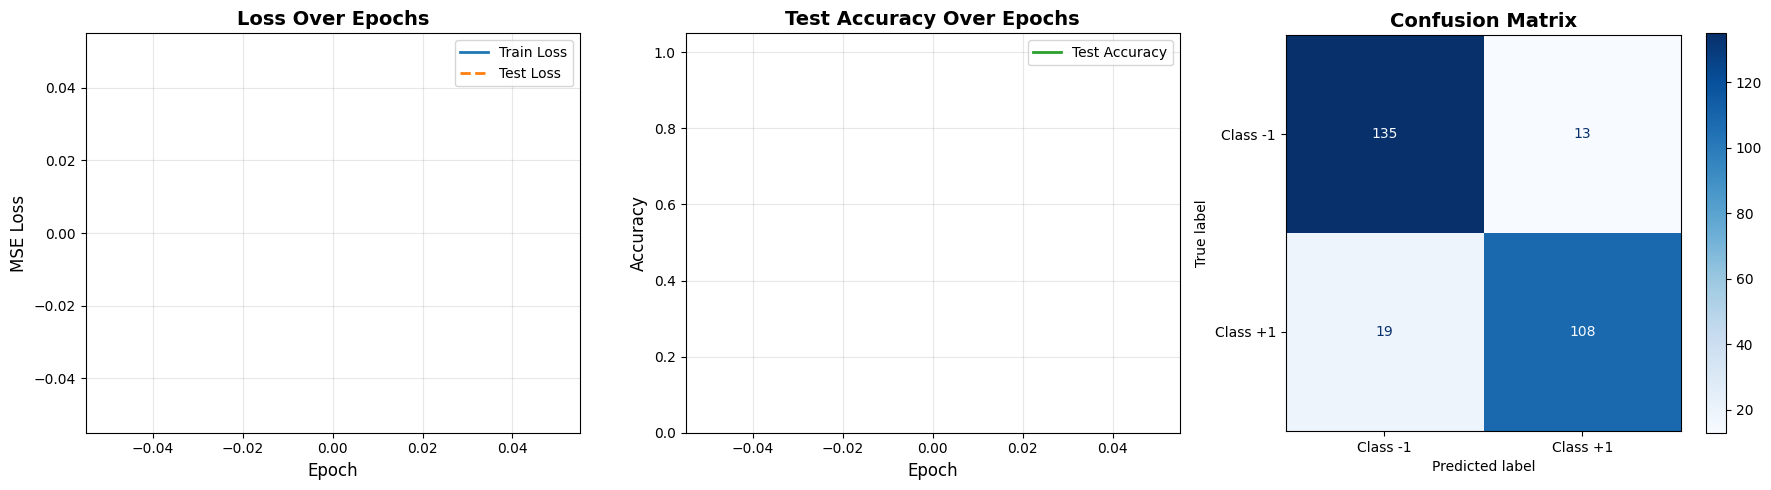

In [ ]:
# Generate predictions on test set
with torch.no_grad():
    test_outputs = model(X_test_tensor).numpy()

# Convert to binary predictions: output > 0 → +1, else → -1
y_pred = np.where(test_outputs > 0, 1, -1).flatten()

# Compute metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, pos_label=1)

print(f"\nFinal Test Performance:")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  F1 Score: {test_f1:.4f}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Training and test loss
epochs_range = range(1, len(train_loss_history) + 1)
axes[0].plot(epochs_range, train_loss_history, label='Train Loss', color='#1f77b4', linewidth=2)
axes[0].plot(epochs_range, test_loss_history, label='Test Loss', color='#ff7f0e', linewidth=2, linestyle='--')
axes[0].set_title('Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('MSE Loss', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Test accuracy
axes[1].plot(epochs_range, test_acc_history, label='Test Accuracy', color='#2ca02c', linewidth=2)
axes[1].set_title('Test Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_ylim([0, 1.05])
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Plot 3: Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class -1', 'Class +1'])
cm_display.plot(ax=axes[2], cmap='Blues', values_format='d')
axes[2].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### **Creating connection with IQM Spark**

In [ ]:
# ---------------------------------------------------------
# Connect to IQM
# ---------------------------------------------------------
try:
    # Replace URL/Token as needed
    provider = IQMProvider("https://odra5.e-science.pl/", token=input("Enter IQM Token: "))
    iqm_backend = provider.get_backend()
    print(f"Connected to backend: {iqm_backend.name}")
except Exception as e:
    print(f"Connection error: {e}")
    # Stop execution if connection fails (optional safety)
    exit()

# ---------------------------------------------------------
# Instantiate the Bridge & QNN
# ---------------------------------------------------------

# Create the hardware estimator
SHOTS = 100
hardware_estimator = IQMBackendEstimator(iqm_backend, options={"shots": SHOTS})

print("Building Hardware QNN for 5 Qubits...")

# Build Circuit Components
hw_ansatz = ansatz(NUM_QUBITS, ANSATZ_DEPTH)

hw_feature_map = model._create_angle_encoding(NUM_QUBITS)

hw_qc = QuantumCircuit(NUM_QUBITS)
hw_qc.compose(hw_feature_map, qubits=range(NUM_QUBITS), inplace=True)
hw_qc.compose(hw_ansatz, inplace=True)

# Observable for 5 Qubits
# "IIZII" measures Qubit 2 (Qiskit is little-endian: q4, q3, q2, q1, q0)
observable = SparsePauliOp.from_list([("I" * 2 + "Z" + "I" * 2, 1)])

# Create QNN with the HARDWARE ESTIMATOR
hw_qnn = EstimatorQNN(
    circuit=hw_qc,
    observables=observable,
    input_params=list(hw_feature_map.parameters),
    weight_params=list(hw_ansatz.parameters),
    estimator=hardware_estimator
)

# Create Torch Layer
iqm_model = TorchConnector(hw_qnn)

# ---------------------------------------------------------
# LOAD TRAINED WEIGHTS
# ---------------------------------------------------------
print("Loading weights...")
try:
    iqm_model.load_state_dict(model.quantum_layer.state_dict())
    print("Trained weights transferred to IQM model successfully!")
except RuntimeError as e:
    print("\n[!] Weight Loading Error: The shape of the trained weights does not match the hardware model.")
    print("Ensure the model you are loading from was trained with N_QUBITS=5 and the exact same ansatz.")
    print(f"Details: {e}")

Enter IQM Token:  q6Oou8ec8Y1up/MFUe/QUHTrINPzR5zHlmLb/SmYDH4BnGJAzFB2gpzjY2YtrtO6


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Connected to backend: IQMBackend
Building Hardware QNN for 5 Qubits...
Loading weights...
Trained weights transferred to IQM model successfully!


###**Hardware Compatibility Check & Single Inference**.

It compiles the quantum circuit for the specific `iqm_backend` to verify efficiency (specifically checking for costly **SWAP gates**) and then runs a single test sample to demonstrate the model's prediction logic in practice.

**Key Metrics:**

* **SWAPs:** Should be **0** if your Star Topology ansatz matches the hardware connectivity.
* **Confidence:** How strongly the qubit collapsed to  or  (0% = random noise, 100% = certain).

In [ ]:
def get_circuit_stats(circuit, backend):
    # Transpile to see how the hardware actually executes it
    t_qc = transpile(circuit, backend, optimization_level=3)
    ops = t_qc.count_ops()
    return {
        'Depth': t_qc.depth(),
        'SWAPs': ops.get('swap', 0),
        'CNOTs/CZs': ops.get('cz', 0) + ops.get('cx', 0)
    }

qnn_circuit = iqm_model.neural_network.circuit
stats = get_circuit_stats(qnn_circuit, iqm_backend)

#Select sample
sample_idx = 67
sample_input = X_test_tensor[sample_idx]
actual_label = y_test_tensor[sample_idx].item()

print(f"Sending job to IQM Spark...")

with torch.no_grad():
    prediction = iqm_model(sample_input)

predicted_label = 1 if prediction.item() > 0 else -1

# --- FINAL COMPARISON TABLE ---
print("\n" + "="*40)
print(f"        HARDWARE PERFORMANCE REPORT")
print("="*40)
print(f"Circuit Depth:      {stats['Depth']}")
print(f"SWAP Gates:         {stats['SWAPs']}  <-- (Target: 0)")
print(f"CZ Gates:           {stats['CNOTs/CZs']}")
print("-" * 40)
print(f"IQM Raw Output:     {prediction.item():.4f}")
print(f"Predicted Class:    {predicted_label}")
print(f"Actual Class:       {int(actual_label)}")
print(f"Confidence Level:   {abs(prediction.item()):.2%}")
print("="*40)

Sending job to IQM Spark...


Progress in queue:   0%|                                                                        | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 180.91ms | Compilation: 217.80ms | Job overall: 2.204s

        HARDWARE PERFORMANCE REPORT
Circuit Depth:      24
SWAP Gates:         0  <-- (Target: 0)
CZ Gates:           16
----------------------------------------
IQM Raw Output:     -0.4200
Predicted Class:    -1
Actual Class:       -1
Confidence Level:   42.00%


In [ ]:
hardware_estimator.print_timing_summary()

for i, ts in enumerate(hardware_estimator.timestamp_history):
    print(f"Job {i}: QPU={ts['execution_time_qpu']:.6f}s, Total={ts['job_time_total']:.4f}s")


DETAILED SUMMARY OF THE TIMESTAMPS
Number of executed jobs: 2

TIME ON QPU :       322.93 ms  (mean: 161.47 ms/job)
Compilation :             287.26 ms  (mean: 143.63 ms/job)
Queue (wait QPU) :   21179.96 ms  (mean: 10589.98 ms/job)
(upload+down) :    1786.78 ms  (mean: 893.39 ms/job)
Others (validation etc):  2211.64 ms

TIME OVERALL:       25788.57 ms (25.789 s)

----------------------------------------
PERCENTAGE DISTRIBUTION: 
  QPU:          1.3%
  Compilation:   1.1%
  Queue:     82.1%
  Network:         6.9%
  Others:         8.6%

Job 0: QPU=0.142024s, Total=23.5844s
Job 1: QPU=0.180909s, Total=2.2041s


### **Time Benchmark**
This code block defines a **benchmarking suite** to evaluate the inference speed (latency) of the Hybrid Quantum Model.

It consists of two functions:

1. **`evaluate_estimator_sample` (Single-Shot):**
* Runs the model **once** on a single input.
* Returns the raw prediction, predicted label, and the exact time taken.
* *Use case:* Quick debugging or checking individual sample latency.


2. **`evaluate_estimator_sample_mean` (Statistical Profiling):**
* Performs a robust performance test using a **Warm-up phase** (to stabilize caches/JIT) followed by a **Loop of 50 repeats**.
* Calculates statistical metrics (Mean, Standard Deviation, Min, Max) to filter out system noise.
* *Use case:* Accurately measuring the "true" speed of the quantum model to see if it meets real-time requirements.



**Summary:** One function is for a quick check; the other is for a professional-grade speed test.

In [ ]:
def evaluate_estimator_sample(model, input_tensor, true_label_tensor):
    model.eval()
    if input_tensor.dim() == 1:
        input_batch = input_tensor.unsqueeze(0)
    else:
        input_batch = input_tensor

    start_time = time.perf_counter()

    with torch.no_grad():
        output = model(input_batch)

    end_time = time.perf_counter()

    time_taken = end_time - start_time

    expectation_value = output.item()
    predicted_label = 1.0 if expectation_value > 0 else -1.0
    true_label = true_label_tensor

    return {
        "expectation_value": expectation_value,
        "predicted_label": predicted_label,
        "true_label": true_label,
        "time_seconds": time_taken
    }

In [ ]:
def evaluate_estimator_sample_mean(model, input_tensor, true_label_tensor, num_repeats=50, warmup=5):
    """
    Benchmarks the forward pass on CPU and prints a formatted summary.
    """
    model.eval()

    # Prepare Input
    if input_tensor.dim() == 1:
        input_batch = input_tensor.unsqueeze(0)
    else:
        input_batch = input_tensor

    # Warm-up
    print(f"Status: Warming up for {warmup} iterations...")
    with torch.no_grad():
        for _ in range(warmup):
            _ = model(input_batch)

    # Measurement Loop
    timings = []
    print(f"Status: Benchmarking over {num_repeats} iterations...")

    with torch.no_grad():
        for _ in range(num_repeats):
            start_time = time.perf_counter()
            output = model(input_batch)
            end_time = time.perf_counter()
            timings.append(end_time - start_time)

    # Calculate Statistics
    avg_time = np.mean(timings)
    std_time = np.std(timings)
    min_time = np.min(timings)
    max_time = np.max(timings)

    # Formatted Print Output
    print("-" * 40)
    print("       BENCHMARK RESULTS       ")
    print("-" * 40)

    # Display in milliseconds (ms) or seconds (s)
    if avg_time < 1.0:
        scale = 1000
        unit = "ms"
    else:
        scale = 1
        unit = "s"

    print(f"Average Time : {avg_time * scale:.4f} {unit}  ± {std_time * scale:.4f} {unit}")
    print(f"Fastest Run  : {min_time * scale:.4f} {unit}")
    print(f"Slowest Run  : {max_time * scale:.4f} {unit}")
    print("-" * 40)

    # Process Final Output
    expectation_value = output.item()
    predicted_label = 1.0 if expectation_value > 0 else -1.0

    return {
        "expectation_value": expectation_value,
        "predicted_label": predicted_label,
        "true_label": true_label_tensor,
        "mean_time_seconds": avg_time,
        "std_dev_seconds": std_time
    }

In [ ]:
results = evaluate_estimator_sample(model, sample_input, actual_label)

# Print the results
print("-" * 30)
print(f"Single Forward Pass (Sample {sample_idx})")
print("-" * 30)
print(f"Expectation Value: {results['expectation_value']:.6f}")
print(f"Predicted Label:   {results['predicted_label']}")
print(f"True Label:        {results['true_label']}")
print(f"Time Taken:        {results['time_seconds']:.10f} sec")
print("-" * 30)

------------------------------
Single Forward Pass (Sample 67)
------------------------------
Expectation Value: -0.488993
Predicted Label:   -1.0
True Label:        -1.0
Time Taken:        0.0932345940 sec
------------------------------


In [ ]:
results_mean = evaluate_estimator_sample_mean(model, sample_input, actual_label)

# Print the results
print("-" * 30)
print(f"Single Forward Pass (Sample {sample_idx})")
print("-" * 30)
print(f"Expectation Value: {results_mean['expectation_value']:.6f}")
print(f"Predicted Label:   {results_mean['predicted_label']}")
print(f"True Label:        {results_mean['true_label']}")
print(f"Time Taken:        {results_mean['mean_time_seconds']:.10f} sec")
print("-" * 30)

Status: Warming up for 5 iterations...
Status: Benchmarking over 50 iterations...
----------------------------------------
       BENCHMARK RESULTS       
----------------------------------------
Average Time : 8.7099 ms  ± 2.0976 ms
Fastest Run  : 6.2199 ms
Slowest Run  : 15.4585 ms
----------------------------------------
------------------------------
Single Forward Pass (Sample 67)
------------------------------
Expectation Value: -0.511659
Predicted Label:   -1.0
True Label:        -1.0
Time Taken:        0.0087099404 sec
------------------------------
